<a href="https://colab.research.google.com/github/warlord02017/App/blob/main/Week5_worksheet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 522 Week 5: Regularization


__Instructor:__ Lyle Ungar

__Content creators:__ Ravi Teja Konkimalla, Mohitrajhu Lingan Kumaraian

**Content reviewers:** Kavish Shah, Ann-Katrin Reuel

#### Ensure you're running a GPU notebook.

From "Runtime" in the drop-down menu above, click "Change runtime type". Ensure that "Hardware Accelerator" says "GPU".

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'sashankv' #@param {type:"string"}
my_pod = 'the-weekenders' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = 'sashankv@seas.upenn.edu' #@param {type:"string"}


# start timing
import time
try:t0;
except NameError: t0 = time.time()

In [ ]:
#@title Import Libraries
from __future__ import print_function
import torch
import pathlib
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from tqdm import tqdm

# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [ ]:
# @title Loading Animal Faces data
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip

In [ ]:
#@title Seeding for Reproducibility
seed = 90108
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.set_deterministic = True
def seed_worker(worker_id):
    worker_seed = seed % (worker_id+1)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def train(args, model, device, train_loader, optimizer, epoch,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
          loss = criterion(output, target)
        elif reg_function2 is None:
          loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
          loss = criterion(output, target)+args['lambda1']*reg_function1(model)+args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()
        # if (batch_idx % args['log_interval'] == 0 and batch_idx != 0):
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                # epoch, batch_idx * len(data), len(train_loader.dataset),
                # 100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, loader = 'Test',criterion=F.nll_loss):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        # loader, test_loss, correct, len(test_loader.dataset),
        # 100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

def main(args, model,train_loader,val_loader,test_data,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
  """
  Trains the model with train_loader and tests the learned model using val_loader
  """

  use_cuda = not args['no_cuda'] and torch.cuda.is_available()
  device = torch.device('cuda' if use_cuda else 'cpu') 

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  best_acc  = 0.0
  best_epoch = 0

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
      train(args, model, device, train_loader, optimizer, epoch,reg_function1=reg_function1,reg_function2=reg_function2)
      train_acc = test(model,device,train_loader, 'Train')
      val_acc = test(model,device,val_loader, 'Val')
      param_norm = calculate_frobenius_norm(model)
      train_acc_list.append(train_acc)
      val_acc_list.append(val_acc)
      param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, model, best_epoch

def calculate_frobenius_norm(model):
    norm = 0.0

    for name,param in model.named_parameters():
        norm += torch.norm(param).data**2
    return norm**0.5



In [ ]:
# @title Network Classes for Animal Faces
class Animal_Net(nn.Module):
    def __init__(self):
        super(Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


class Big_Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Big_Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 124)
        self.fc2 = nn.Linear(124, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# @title Dataloder
batch_size = 128
classes = ('cat', 'dog', 'wild')

train_transform = transforms.Compose([
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
     ])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

train_loader = torch.utils.data.DataLoader(img_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(img_val_data,batch_size=1000,worker_init_fn=seed_worker)

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

#Section 0: Hyper Parameter Tuning


Video available at https://youtube.com/watch?v=-ly5hwbpx-w


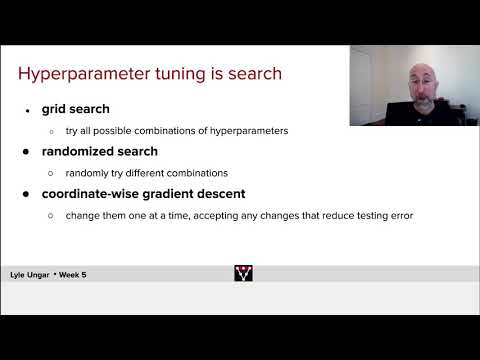

In [ ]:
#@title Video : Tuning Methods
try: t1;
except NameError: t1=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="-ly5hwbpx-w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

While hyper parameter tuning is quite laborious it is also a major part of training any deep learning model and paramount for incorporating good generalization capabilities. There are a few techniques that we can use to guide us during the search. 


*   Grid Search: Try all possible combinations of hyperparameters
*   Random Search: Randomly try different combinations of hyperparameters
*   Coordinate-wise Gradient Descent: Start at one set of hyperparameters and try changing one at a time, accept any changes that reduce your validation error
*   Bayesian Optimization/ Auto ML:  Start from a set of hyperparameters that have worked well on a similar problem, and then do some sort of local exploration (e.g. gradient descent) from there.

There are lots of details, like what range to explore over, which parameter to optimize first, etc. Some hyperparameters don’t seem to matter much (people use a dropout of either 0.5 or 0, but not much else).  Others can matter a lot more (e.g. size and depth of the neural net). The key is to see what worked on similar problems.

You can automate the process of tuning the network architecture using Neural Architecture Search which designs new architectures using a few building blocks (Linear, Convolutional, Convolution Layers, etc.) and optimizes the design based on performance using a wide range of techniques such as Grid Search, Reinforcement Learning, GD, Evolutionary Algorithms, etc. This obviously requires very high computer power. Read this [article](https://lilianweng.github.io/lil-log/2020/08/06/neural-architecture-search.html) to learn more about NAS.    


#Section 1: Stochastic Gradient Descent



Video available at https://youtube.com/watch?v=E3g2Z-ZqMZw


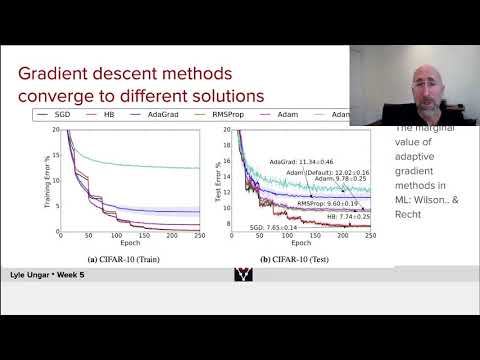

In [ ]:
#@title Video : SGD
try: t2;
except NameError: t2=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="E3g2Z-ZqMZw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Learning Rate
In this section below we will see how learning rate can act as regularizer while training the neural network. In summary:


*   A smaller Learning rate does not regularize well. Rather it slowly converges to a local deep minima. 
*   A larger Learning rate regularizes well by missing local minima and finding a broader, flatter minimum. These minima may be more robust.

But beware, taking a very large learning rate may result in overshooting or finding a really bad local minima.



In the below block we will train the Animal Net model with different learning rates and see how that is going to affect the regularization performance.

In [ ]:
#@title Generating Data Loaders
batch_size = 128
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
     ])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
img_train_data, img_val_data, = torch.utils.data.random_split(img_dataset, [11700,2930])

full_train_loader = torch.utils.data.DataLoader(img_train_data,batch_size=batch_size,num_workers=4,worker_init_fn=seed_worker)
full_val_loader = torch.utils.data.DataLoader(img_val_data,batch_size=1000,num_workers=4,worker_init_fn=seed_worker)

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # [TO-DO]
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)
# img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,shuffle=False, num_workers=1)
classes = ('cat', 'dog', 'wild')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 350,
        'batch_size': 32,
        'momentum': 0.99,
        'no_cuda': False
        }

lr = [5e-4,1e-3, 5e-3]
acc_dict = {}

for i in range(len(lr)):
    model = Animal_Net()
    args['lr'] = lr[i]
    val_acc, train_acc, param_norm,_,_ = main(args,model,train_loader,val_loader,img_test_dataset)
    acc_dict['val_'+str(i)] = val_acc
    acc_dict['train_'+str(i)] = train_acc
    acc_dict['param_norm'+str(i)] = param_norm

100%|██████████| 350/350 [01:08<00:00,  5.11it/s]


Maximum Test Accuracy obtained with lr = 5e-4: 65.0
Maximum Test Accuracy obtained with lr = 1e-3: 64.0
Maximum Test Accuracy obtained with lr = 5e-3: 63.0


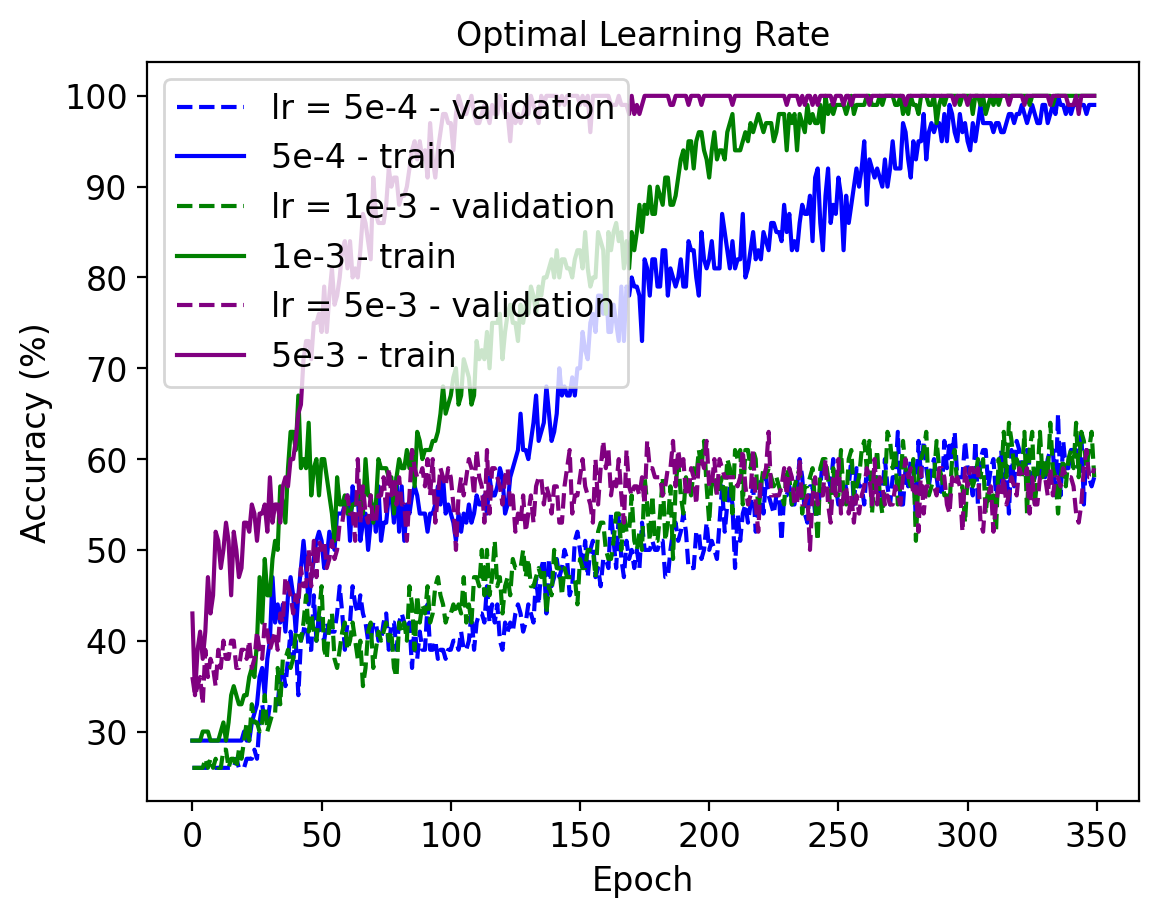

In [ ]:
#@title Plot Train and Validation accuracy (Run me)
plt.plot(acc_dict['val_0'], linestyle='dashed',label='lr = 5e-4 - validation', c = 'blue')
plt.plot(acc_dict['train_0'],label = '5e-4 - train', c = 'blue')
plt.plot(acc_dict['val_1'], linestyle='dashed',label='lr = 1e-3 - validation', c = 'green')
plt.plot(acc_dict['train_1'],label='1e-3 - train', c = 'green')
plt.plot(acc_dict['val_2'], linestyle='dashed',label='lr = 5e-3 - validation', c = 'purple')
plt.plot(acc_dict['train_2'],label = '5e-3 - train', c = 'purple')
plt.title('Optimal Learning Rate')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
print('Maximum Test Accuracy obtained with lr = 5e-4: '+str(max(acc_dict['val_0'])))
print('Maximum Test Accuracy obtained with lr = 1e-3: '+str(max(acc_dict['val_1'])))
print('Maximum Test Accuracy obtained with lr = 5e-3: '+str(max(acc_dict['val_2'])))
plt.legend()
plt.show()

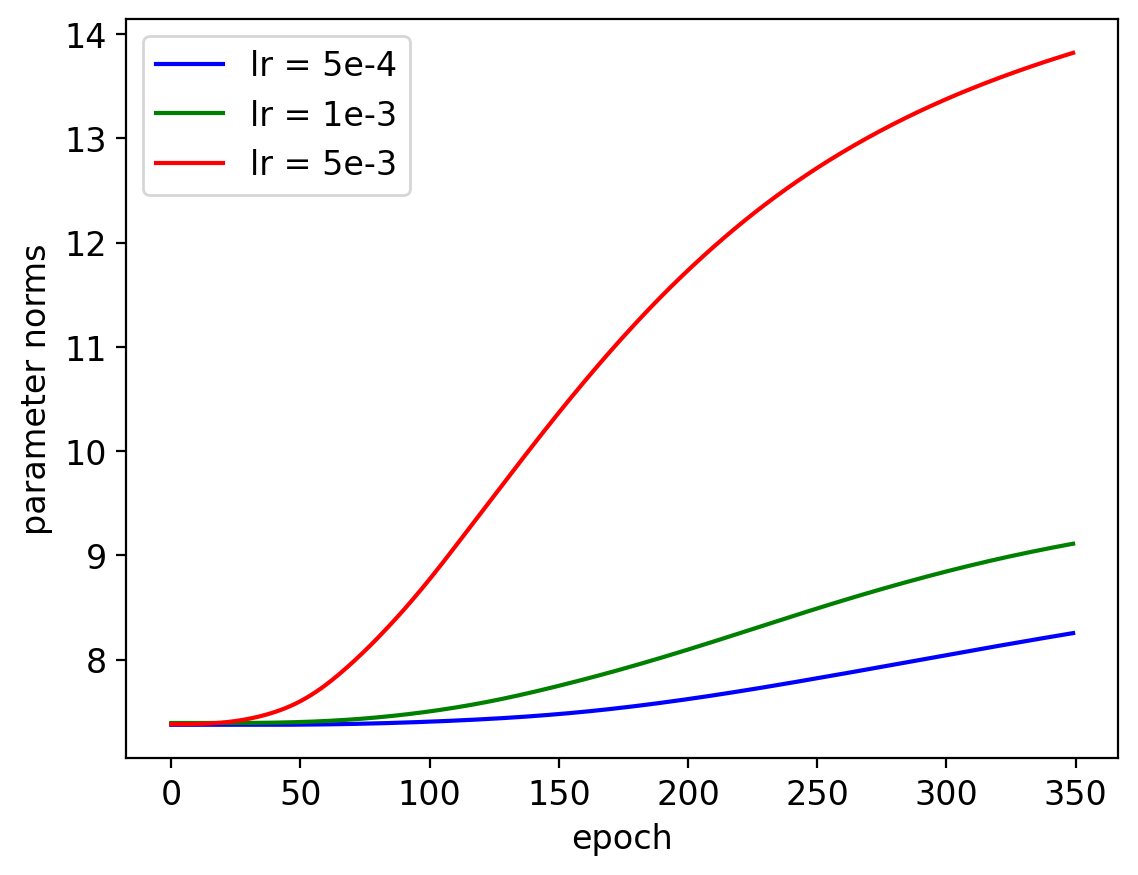

In [ ]:
#@title Plot parametric norms (Run me)
plt.plot(acc_dict['param_norm0'],label='lr = 5e-4',c='blue')
plt.plot(acc_dict['param_norm1'],label = 'lr = 1e-3',c='green')
plt.plot(acc_dict['param_norm2'],label ='lr = 5e-3', c='red')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('parameter norms')
plt.show()

**Quiz Question 1:** Describe your takeaways from the two plots above. Did you expect these curves? Is there something you found surprising? (open-ended question, no right or wrong answer)

In [ ]:
learning_rate = 'From the above plots we observe that the model with the smallest learning rate is achieving the highest maximum test accuracy. In general, we observe that as the learning rate is increasing, the maximum test accuracy is decreasing. This is the exact opposite of what we were expecting since a smaller learning rate means less regularization which means it should not generalize well.  We also observe from the second plot that as the learning rate is increasing, the average value of parameter norms (i.e. the value on the y-axis) is increasing. We did not expect these curves at all after reading the passage of text that was given before these plots. Because, we expected that a smaller learning rate does not regularize well, so therefore, smaller learning rate means less regularization which means bigger values of parameter norms \u2013 which is the exact opposite of what we observe from the given plots. We see from the plots that the smaller the learning rate is, the smaller is the value of parameter norms. This is exactly opposite of what we had expected.' #@param {type:"string"}

## Batch Size
Batch size, in some cases, can also help in regularizing the models. Lower batch size leads to a noisy convergence and hence helps in converging to a broader local minima. Whereas, higher batch size lead to a smoother convergence thereby converging easily to a  deeper local minima.  This can be good or bad.

In the below blcok we will train the Animal Net model with different batch sizes and see how that is going to affect the regularization performance.

In [ ]:
#@title Dataset for Batch_size
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
reg_train_data, reg_val_data,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])


In [ ]:
args = {'lr': 5e-3,
        'epochs': 60,
        'momentum': 0.99,
        'no_cuda': False
        }

batch_sizes = [32,64,128]
acc_dict = {}

for i in range(len(batch_sizes)):
    model = Animal_Net()
    #Creating train_loader and Val_loader
    reg_train_loader = torch.utils.data.DataLoader(reg_train_data,batch_size=batch_sizes[i],worker_init_fn=seed_worker)
    reg_val_loader = torch.utils.data.DataLoader(reg_val_data,batch_size=1000,worker_init_fn=seed_worker)
    val_acc, train_acc,param_norm,_,_ = main(args,model,reg_train_loader,reg_val_loader,img_test_dataset)
    acc_dict['train_'+str(i)] = train_acc
    acc_dict['val_'+str(i)] = val_acc
    acc_dict['param_norm'+str(i)] = param_norm

100%|██████████| 60/60 [00:17<00:00,  3.43it/s]


maximum accuracy for mini batchsize = 32: 74.0
maximum accuracy for mini batchsize = 64: 79.0
maximum accuracy for mini batchsize = 128: 72.0


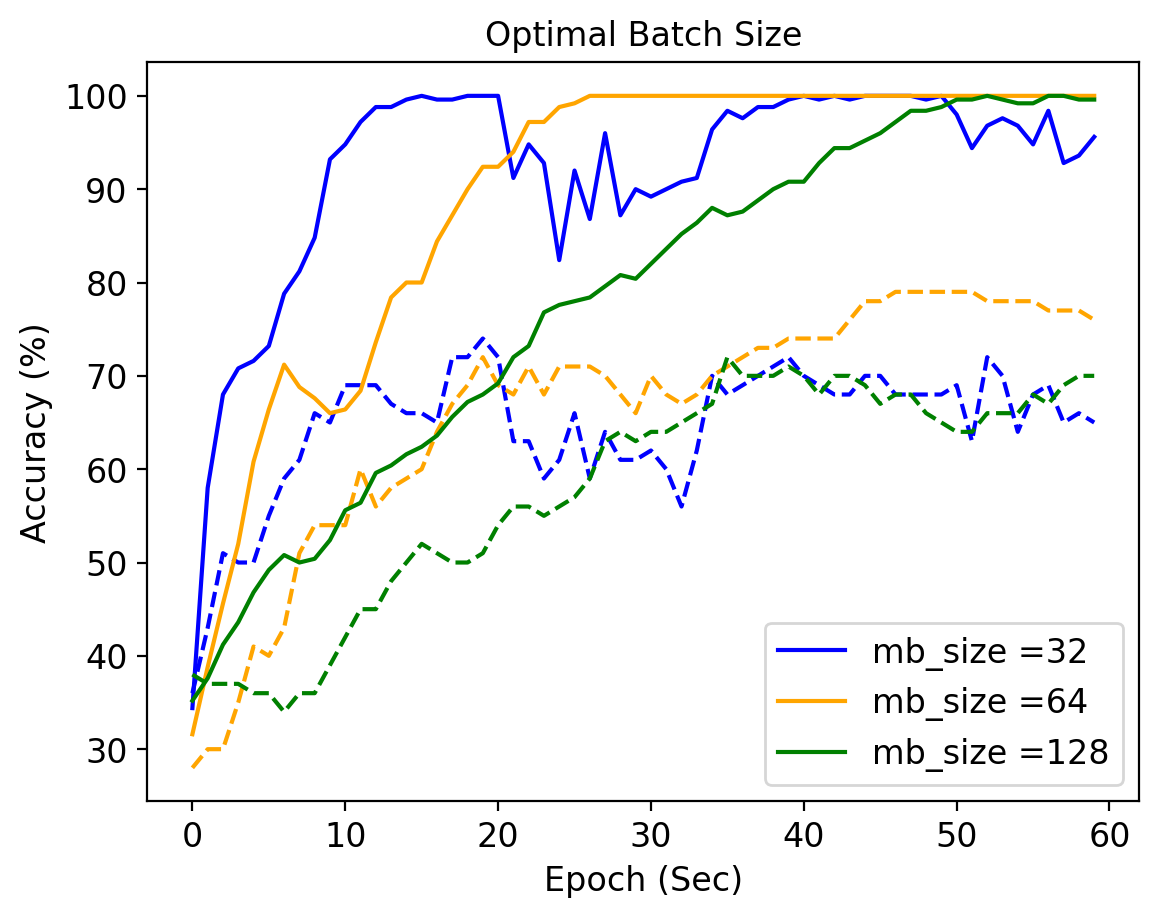

In [ ]:
#@title Plot Train and Val curves
plt.plot(acc_dict['train_0'], label='mb_size =' + str(batch_sizes[0]), c = 'blue')
plt.plot(acc_dict['val_0'], linestyle='dashed', c = 'blue')

plt.plot(acc_dict['train_1'], label='mb_size =' + str(batch_sizes[1]), c = 'orange')
plt.plot(acc_dict['val_1'], linestyle='dashed', c = 'orange')
plt.plot(acc_dict['train_2'], label='mb_size =' + str(batch_sizes[2]), c = 'green')
plt.plot(acc_dict['val_2'], linestyle='dashed', c = 'green')
print('maximum accuracy for mini batchsize = 32: '+str(max(acc_dict['val_0'])))
print('maximum accuracy for mini batchsize = 64: '+str(max(acc_dict['val_1'])))
print('maximum accuracy for mini batchsize = 128: '+str(max(acc_dict['val_2'])))

plt.title('Optimal Batch Size')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch (Sec)')
plt.legend()
plt.show()

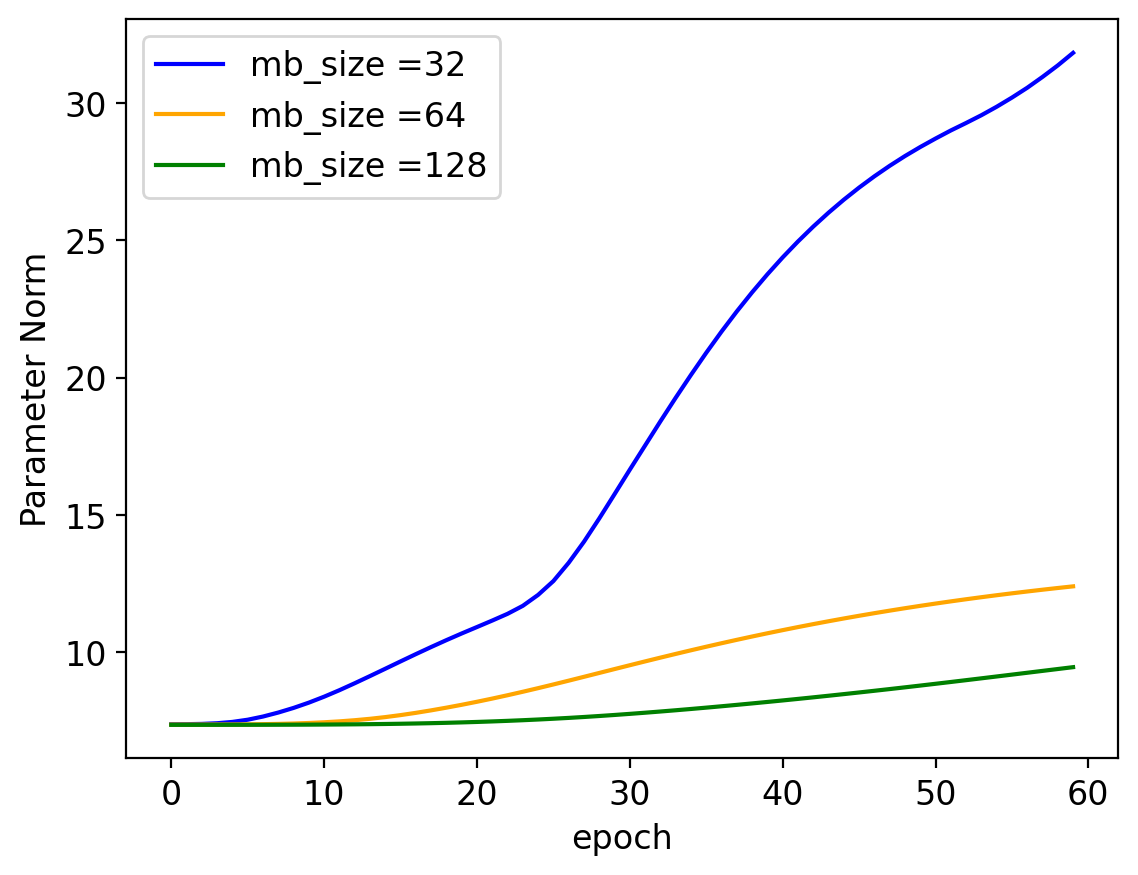

In [ ]:
#@title Plot Parametric Norms
plt.plot(acc_dict['param_norm0'],c='blue',label='mb_size =' + str(batch_sizes[0]))
plt.plot(acc_dict['param_norm1'],c='orange',label='mb_size =' + str(batch_sizes[1]))
plt.plot(acc_dict['param_norm2'],c='green',label='mb_size =' + str(batch_sizes[2]))
plt.xlabel('epoch')
plt.ylabel('Parameter Norm')
plt.legend()
plt.show()
plt.show()

**Quiz Question 2:** What observation can you make for different batch size. Why do you think this is happening? (open-ended question, no right or wrong answer)

In [ ]:
batch_size = 'We observe from the parametric norms plot that the higher the batch size, the lower is the parameter norm value. This is the exactly opposite of what we expect after reading the text excerpt that was given before this code block which suggested that the higher the batch size, the lower should be regularization, therefore the higher should be the parameter norm values. We also observe from the train and validation curve plot, that having a larger batch size (which means less regularization, which means not so good generalization) results in the validation accuracy curve for batch size 128 being lower than the validation accuracy curve for batch size 32 and 64 which is consistent to what we expect. Also, we observe for batch size 32 that since it theoretically has more regularization since it tends to explore more, it generalizes well on test data which is evident from the plot. The validation curve for batch size 64 seems to be a sweet spot in the trade-off between generalization accuracy and between smooth convergence of the network.' #@param {type:"string"}

#Section 2: Pruning


Before we dig deeper into pruning let's take a small detour and calculate the inference time (time taken for one forward pass during testing) and the number of parameters of the biggest model we'll train this week.


```
class Animal_Net_Dropout(nn.Module):
    def __init__(self):
        torch.manual_seed(32)
        super(Animal_Net_Dropout, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 124)
        self.fc2 = nn.Linear(124, 64)
        self.fc3 = nn.Linear(64, 3)
```



##Exercise 1: Calculating Inference

Now calculate by hand the exact total number of parameters and fill in the code below to calculate the average inference time of the above model.

In [ ]:
def calculate_inference(N):

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the calculate inference function")
    ####################################################################

    total_time = 0.0
    model = Big_Animal_Net()
    model.eval()
    
    for i in range(N):
        #generate random data of batch 1 which should be passed into the model
        X = torch.rand(1,3,32,32)
        #make sure you don't calculate gradients to make the compute faster
        with torch.no_grad(): 
            start_time = time.time()
            y = model(X)
            end_time = time.time()
            total_time+= end_time - start_time

    print(f'Inference time of the above network is: {total_time/N}')

##uncomment to run
calculate_inference(1000)

Inference time of the above network is: 0.00014644026756286622


In [ ]:
#@markdown **Quiz Question 3:** What is the number of parameters of the biggest model we'll train this week?
number_of_parameters = '389247' #@param {type:"string"}

But this obviously isn't the best network we can do. We can use a bigger network and train on bigger dataset, infact the entire Animal Faces Dataset consists of about around 15000 training data.Also, we have to keep in mind that the images we are using are of very low resolution(32X32), the sizes of the images in the original dataset is 512X512. While this will definetly improve the performance of the model it will also increase the resources needed to handle the model.

Google is known for training very big language models and recently it trained a [trillion parameter](https://thenextweb.com/neural/2021/01/13/googles-new-trillion-parameter-ai-language-model-is-almost-6-times-bigger-than-gpt-3/) model. This is almost 1.2e6 times bigger than the model we just trained. So it is sufficient to say that these big models need intense compute power to train while also becomeing harder to deploy and get real time inference on smaller micro - proccesors. 

This is where regularization and pruning come in very handy. Until now you should have noticed that the Frobenious norm of the regularized models that we trained tend to be smaller than those of unregualrized models. This indicates that the regualarization is shrinking the weights (making the model sparser) while improving the test performance. 

While methods like L1 regulartization promote implicit sparsity, in pruning we explicitly set a few weights of the tained model to zero and then retrain the model to adjust the other weights. This reduces the memory consumption, improves inference and helps the planet :)


Video available at https://youtube.com/watch?v=7S5LA2OFdzs


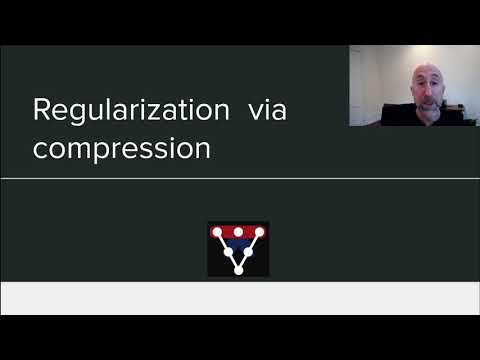

In [ ]:
#@title Video :  Pruning
try: t3;
except NameError: t3=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7S5LA2OFdzs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

One of the most common methods of pruning a NN is to zero out a certain percentage of parameters based on their L1 norm. We don't actually remove the parameters because that makes forward computations difficult.

Luckily we have Pytorch's torch.nn.utils.prune methods to play around and test pruning.

##Exercise 2: L1Prune
Before we train a pruned model let us write a function to prunes a model. Use the [prune.L1Unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html#torch.nn.utils.prune.l1_unstructured) method.

In [ ]:
def prune_l1_unstructured(model,prune_percent_weight,prune_percent_bias = 0):
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the calculate inference function")
    ####################################################################

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            #Prune both weight and bias using the prune_percent_weight and prune_percent_bias
            prune.l1_unstructured(module,name="weight",amount = prune_percent_weight)
            prune.l1_unstructured(module,name="bias", amount = prune_percent_bias)

            print(
                "Sparsity in {}: {:.2f}%".format(name,
                    100. * float(torch.sum(module.weight == 0))
                    / float(module.weight.nelement())
                )
            )
##uncomment to run the test
test_model = Animal_Net()
prune_percent = 0.15
prune_l1_unstructured(test_model,0.15)

Sparsity in fc1: 15.00%
Sparsity in fc2: 14.99%
Sparsity in fc3: 14.58%


In the section below, you will see the working of a very simple pruning technique which prunes a percentage of the parameters based on their weights.

Training a randomly initialized model


100%|██████████| 200/200 [00:37<00:00,  5.32it/s]


Pruning and verifying and model:
Sparsity in fc1: 98.00%
Sparsity in fc2: 98.00%
Sparsity in fc3: 97.92%
Training a pruned model


100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


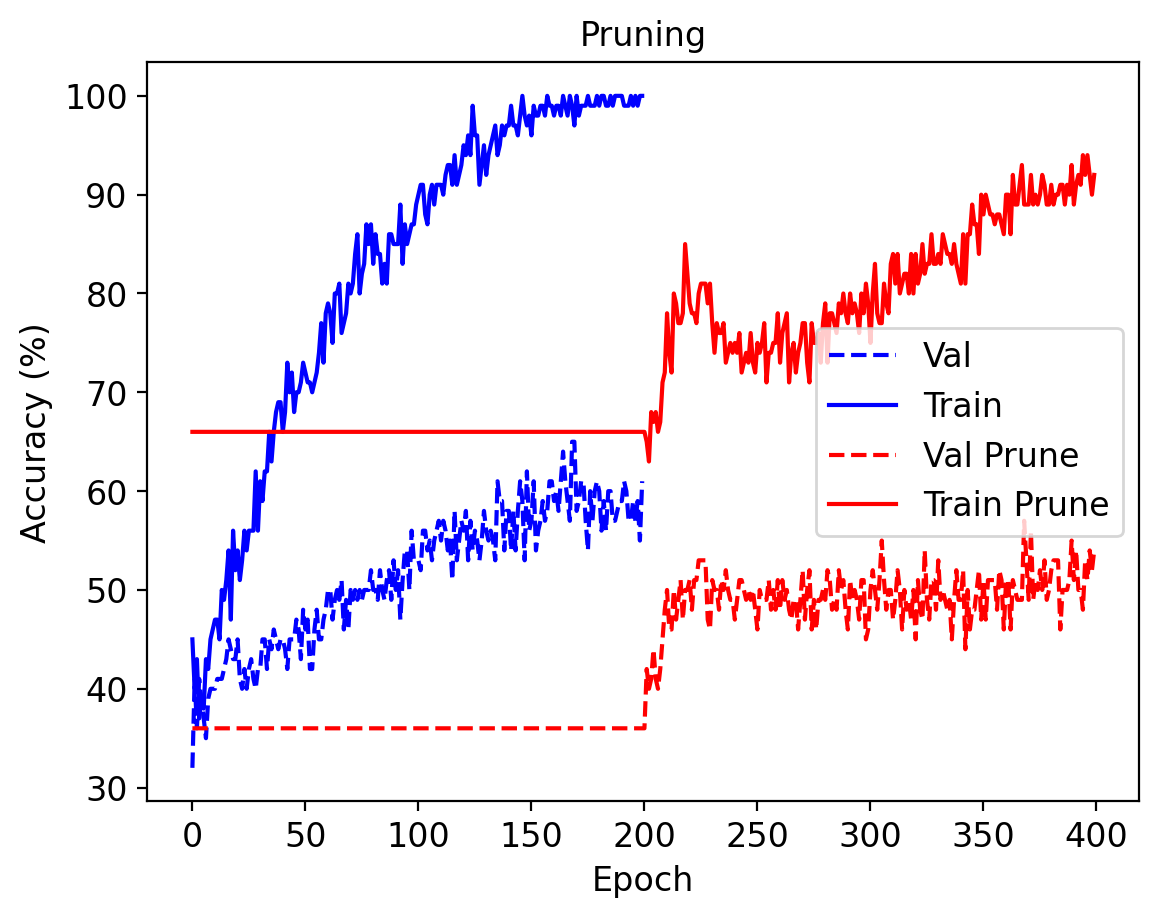

In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False
        }

acc_dict = {}
model = Big_Animal_Net()
prune_percent = 0.98

print("Training a randomly initialized model")
val_acc, train_acc, _, trained_model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)

##pruning a model
print('Pruning and verifying and model:')
prune_l1_unstructured(trained_model,prune_percent)

#training the pruned model
print("Training a pruned model")
val_acc_prune, train_acc_prune, _, pruned_model ,_ = main(args,trained_model.to('cpu'),train_loader,val_loader,img_test_dataset)

val_acc_prune = [val_acc_prune[0]]*args['epochs'] + val_acc_prune
train_acc_prune = [train_acc_prune[0]]*args['epochs'] + train_acc_prune
plt.plot(val_acc,label='Val',c='blue',ls = 'dashed')
plt.plot(train_acc,label='Train',c='blue',ls = 'solid')
plt.plot(val_acc_prune,label='Val Prune',c='red',ls = 'dashed')
plt.plot(train_acc_prune,label='Train Prune',c='red',ls = 'solid')
plt.title('Pruning')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Quiz Question 4:** Now change the prune_percent and report the percentage at which the model underfits.

In [ ]:
pruning_percent = '98% (0.98)' #@param {type:"string"}

**Quiz Question 5:** Let's say you create a new model where the number of parameters equals to the number of parameters left after pruning. Do you think this model will work as good as the model which we get after pruning the larger network? (open-ended question, no right or wrong answer)

In [ ]:
under_parameterized_model = 'No, in my opinion the larger network that underwent pruning will perform better than the new model with as many number of parameters as the pruned model. This is because the pruned model begins as a larger network that undergoes training and it has larger number of parameters because of which it learns effectively and then we prune a bunch of these parameters based on a specific criteria. It is difficult for a new model with as many number of parameters as there are in the pruned model to mimic the kind of learning that the pruned model underwent. This is because the pruned model selects a subset of the parameters that it chooses to keep in the model therefore making it more effective. But this will not be the case if we initialize a model with as many number of parameters as the pruned model (after pruning) to begin with.' #@param {type:"string"}

**Quiz Question 6:** Given the above pruning technique, after pruning the network, how do you think the performance will change if we re-initialize the weights while maintaing the prune mask? (open-ended question, no right or wrong answer)

In [ ]:
pruning_re_init = 'As we are maintaining the prune mask and re-initializing only the other weights, I believe the network would eventually manage to perform as good as the original pruned network after sufficient number of epochs given that we initialize this model\u2019s weights with the same initialization that was used for the original network before pruning. This is because, by maintaining the pruned mask, we are effectively fixing which parameters in the network are crucial. This, in a way, transfers our knowledge of which weights are important and which ones are not into the re-initialized model and helps build as good as a model as the original pruned model. However, if we change this initialization method, then it is not guaranteed that the re-initialized model\u2019s performance will match the pruned model\u2019s performance.' #@param {type:"string"}

## Lottery Tickets


The lottery ticket hypothesis claims that " A dense randomly initialized NN contains a subnetwork that is initialzed such that when trained in isolation it can match the test accuracy of the original network after training for at most same number of iterations" i.e. a pruned model when reinitialized with the same weights will can match the test accuracy of the denser model. If the initialization changes the accuracy match is no longer guaranteed.




Here we train the following networks:


1.   An unregularized model with Xavier initialization of weights for 200 epochs
2.   A Pruned model with the weights reinitialized to the random values.
3.   A pruned model with weights initialized with same Xavier Initialization as unregularized model.


Training the full model


100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Sparsity in fc1: 40.00%
Sparsity in fc2: 39.99%
Sparsity in fc3: 40.10%
Training the pruned and Xavier model


100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


Training the pruned Init model


100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


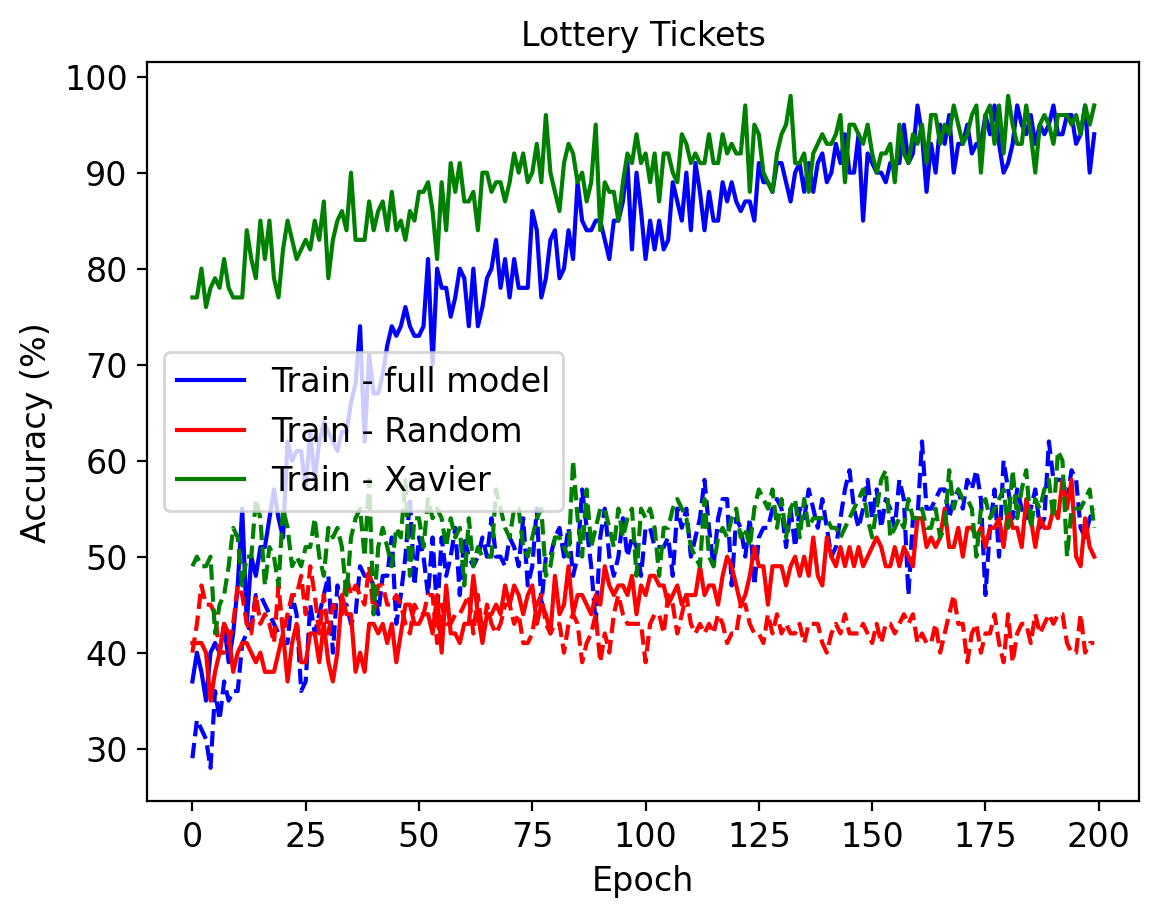

In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 1e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}
init_model = Big_Animal_Net()
xavier_model = Big_Animal_Net()
prune_percent = 0.4

#Xavier Initilaization for one of the two models
for name, module in xavier_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)

print('Training the full model')
val_acc, train_acc, _, trained_model ,_ = main(args,copy.deepcopy(xavier_model),train_loader,val_loader,img_test_dataset)


#prune the trained model
prune_l1_unstructured(trained_model,prune_percent)

#initialize masks for the initialzed model and xavier model
for name, module in init_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.identity(module, name='weight')
        prune.identity(module, name='bias')

for name, module in xavier_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.identity(module, name='weight')
        prune.identity(module, name='bias')

init_modules = [[name,module] for name, module in init_model.named_modules()]
xavier_modueles = [[name,module] for name, module in xavier_model.named_modules()]
trained_modules = [[name,module] for name, module in trained_model.named_modules()]

for i in range(len(init_modules)):
    if isinstance(init_modules[i][1], torch.nn.Conv2d) or isinstance(init_modules[i][1], torch.nn.Linear):
        init_modules[i][1].weight_mask = copy.deepcopy(trained_modules[i][1].weight_mask) 
        init_modules[i][1].bias_mask = copy.deepcopy(trained_modules[i][1].bias_mask)

for i in range(len(xavier_modueles)):
    if isinstance(xavier_modueles[i][1], torch.nn.Conv2d) or isinstance(xavier_modueles[i][1], torch.nn.Linear):
        xavier_modueles[i][1].weight_mask = copy.deepcopy(trained_modules[i][1].weight_mask) 
        xavier_modueles[i][1].bias_mask = copy.deepcopy(trained_modules[i][1].bias_mask)


print('Training the pruned and Xavier model')
val_acc_lottery_x, train_acc_lottery_x, _, pruned_model_x ,_ = main(args,xavier_model,train_loader,val_loader,img_test_dataset)
print('Training the pruned Init model')
val_acc_lottery, train_acc_lottery, _, pruned_model ,_ = main(args,init_model,train_loader,val_loader,img_test_dataset)

plt.plot(val_acc,c='blue',ls = 'dashed')
plt.plot(train_acc,label='Train - full model',c='blue',ls = 'solid')
plt.plot(val_acc_lottery,c='red',ls = 'dashed')
plt.plot(train_acc_lottery,label='Train - Random',c='red',ls = 'solid')
plt.plot(val_acc_lottery_x,c='green',ls = 'dashed')
plt.plot(train_acc_lottery_x,label='Train - Xavier',c='green',ls = 'solid')
plt.title('Lottery Tickets')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Quiz Question 7:** Why does the first training epoch of lottery ticket have such a high training accuracy?

In [ ]:
lottery_tickets = 'The first training epoch of lottery ticket has such a high training accuracy because it kind of builds on top of the knowledge that our full model acquired during the end of training process \u2013 i.e. the lottery ticket model is given which set of parameters/weights are the important ones (by our full model since we maintain the prune mask) and re-initialize the lottery ticket model using Xavier initialization, which is the same kind of distribution that was used to initialize our full model during training. Hence, the lottery ticket model has such a high training accuracy during the first epoch as we observe from the plot.' #@param {type:"string"}

#Section3: Distillation


Bigger neural nets are better for model performance but require significant memory, while smaller networks tend be be less accurate but are easier to deploy and use. 

Distillation is a technique which allows us to train smaller networks such that they mimic the outputs of the bigger network. The bigger network is called the teacher network wheras the smaller one is the student network. 

Distillation begins by training a teacher network. It then trains the student network with both the original labels and "soft" labels--the output of the teacher model. This lets us train the student network on unlabelled datasets, using the labeled given by the teacher network. 

Video available at https://youtube.com/watch?v=y_KzDpklMmE


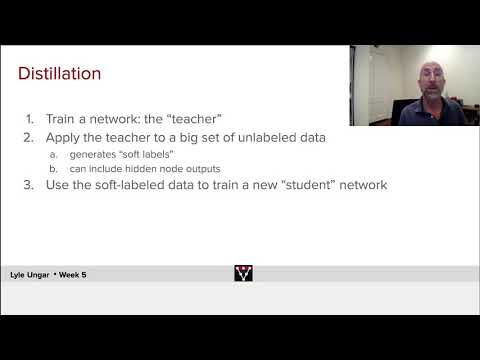

In [ ]:
#@title Video : Distillation
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="y_KzDpklMmE", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Let's begin by desiging a smaller network and training the parent model and also the small model using hard labels.

In [ ]:
class Small_Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(32)
        super(Small_Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
#@title Train the models (Run Me!)
args = {'test_batch_size': 1000,
        'epochs': 200,
        'momentum': 0.9,
        'no_cuda': False,
        'lr' : 5e-3,
        'cross_entropy':True
        }

Bmodel = Big_Animal_Net()
Smodel = Small_Animal_Net()

val_acc_big, train_acc_big, _, trained_big_model ,_ = main(args,Bmodel,train_loader,val_loader,img_test_dataset)
val_acc_small, train_acc_small, _, _ ,_ = main(args,Smodel,train_loader,val_loader,img_test_dataset)

100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


Loss Function:

We use the same cross entropy loss as before but we use both hard and soft labels to calculate loss. We cannot directly use the CrossEntropy Loss in Pytorch to calculate loss for soft labels. Hence we will exploit the relation between Cross Entropy and KL Divergence. 

Cross Entropy loss and KL Divergence are both related by: H(p,q) = H(p) + KL(p,q) where H(p,q) calculates cross entropy loss between distributions p and q wheras KL represents KL divergence. Here p is the probability distribution of soft_outputs which are constant and hence we can omit from the loss function.

        L = (1 - alpha)*CE(outputs,ground_truth) + alpha * (T**2) *CE(outputs,soft_targets)
        L = (1 - alpha)*CE(outputs,ground_truth) + alpha * (T**2) *KL(outputs,soft_targets)

Here alpha and temperature are hyper parameters where temperatures is used to smoothen the outputs of the parent network. 

[Click to learn more about the relation](https://adventuresinmachinelearning.com/cross-entropy-kl-divergence/)

In [ ]:
def distillation_loss(args,soft_outputs, pred_logits, target):

    alpha = args['alpha']
    T = args['temperature']
    dist_loss = (1. - alpha) * F.cross_entropy(pred_logits, target) + \
                    (alpha * (T ** 2)) * F.kl_div(F.log_softmax(pred_logits/T, dim=1),
                             F.softmax(soft_outputs/T, dim=1))

    return dist_loss

In [ ]:
#@title Modified Train Functions (Run Me!)
def train_softmax_distillation(args, student_model,parent_model, device, train_loader, optimizer, epoch):
    
    student_model.train()
    parent_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        soft_outputs = parent_model(data)
        pred_logits = student_model(data)
        loss = distillation_loss(args,soft_outputs.detach(), pred_logits, target)
        loss.backward()
        optimizer.step()

In [ ]:
#@title Modified Main Function (Run Me!)
def distilation_main(args, teacher_model,student_model,train_loader,val_loader):

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)
    optimizer = optim.SGD(student_model.parameters(), lr=args['lr'], momentum=args['momentum'])
    val_acc_list = []
    train_acc_list = []
    for epoch in tqdm(range(1, args['epochs'] + 1)):
        train_softmax_distillation(args, student_model,teacher_model, device, train_loader, optimizer, epoch)
        train_acc = test(student_model,device,train_loader,'Train')
        val_acc = test(student_model,device,val_loader,'Val')
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)

    return val_acc_list, train_acc_list, student_model

Now that we have everything ready let's train the student network.

In [ ]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'momentum': 0.9,
        'no_cuda': False,
        'lr' : 5e-3,
        'alpha': 1,
        'temperature': 40
        }

student_model = Small_Animal_Net()

val_acc_st, train_acc_st, _, = distilation_main(args,trained_big_model,student_model,train_loader,val_loader)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


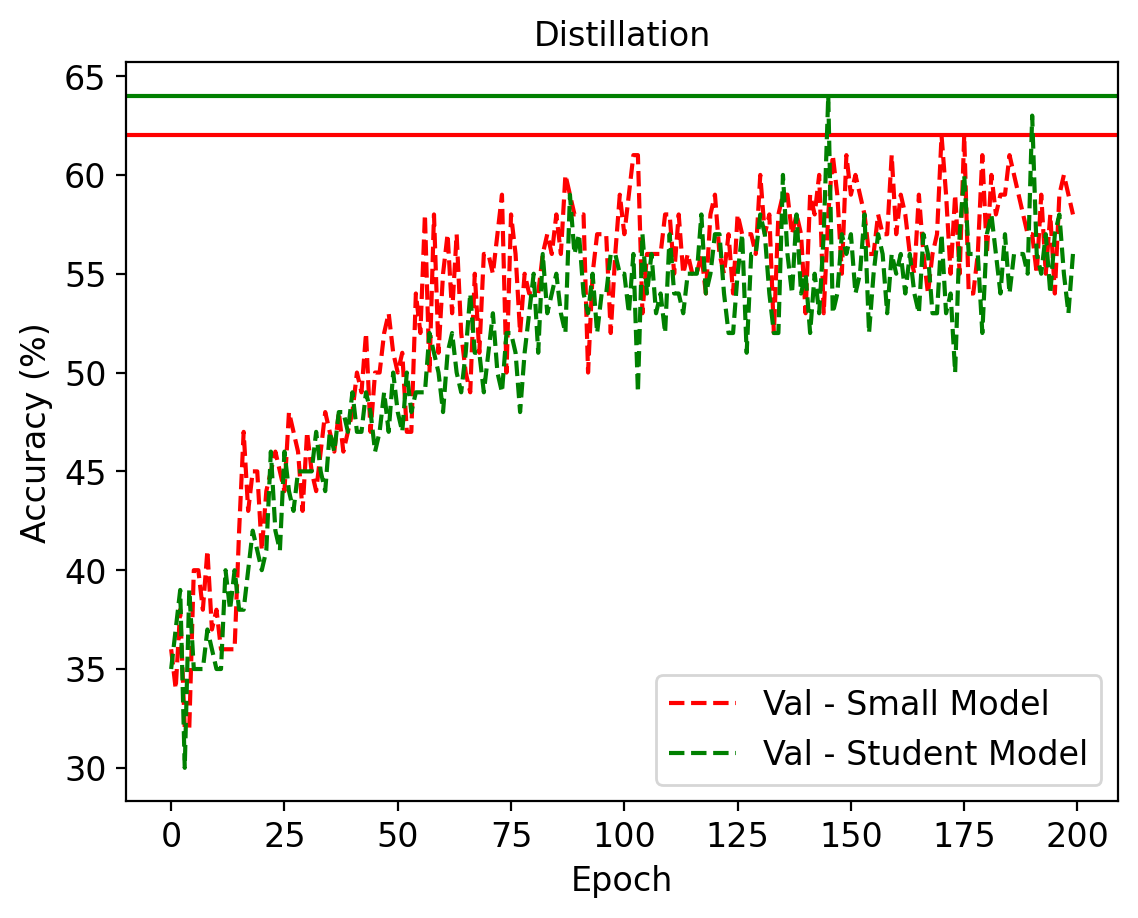

In [ ]:
#@title Plot the validation curves of small model trained on hard and soft labels 
plt.plot(val_acc_small,label='Val - Small Model',c='red',ls = 'dashed')
plt.axhline(y = max(val_acc_small),c = 'red')
plt.plot(val_acc_st,label='Val - Student Model',c='green',ls = 'dashed')
plt.axhline(y = max(val_acc_st),c = 'green')
plt.title('Distillation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

This method not only provides a way to train small and better networks but also gives us a chance to train small networks on more data using the soft labels from the heavily optimized parent networks.

**Quiz Question 8:** What other techniques can you use to reduce the dimensionality or size of the big network or the input data? (open-ended question, no right or wrong answer)

In [ ]:
distillation = 't-SNE; PCA; SVD and Spectral embeddings are some of the techniques that can be used to achieve this.' #@param {type:"string"}

**Quiz Questino 9:** Do you think regularization helps when you have infinite data available? (open-ended question, no right or wrong answer)

In [ ]:
data = 'I think regularization does not help when we have infinite data available. This is because if we have infinite data available then our model will be able to essentially train on infinite training points and since fitting every single one of these training points would guarantee that the model is 100% accurate, in this case we want the model to be as complex as possible and fit all of the infinite points perfectly. Since regularizing the model will not allow the model to do so, I think that regularization does not help in such a scenario.' #@param {type:"string"}

# Section 4: Adversarial  Attacks


In [ ]:
#@title Video : Adversarial
try: t5;
except NameError: t5=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2e-PxxlGfpM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Designing perturbations to the input data to trick any machine learning model is called Adversarial attacks. These attacks are an inevitable consequence of learning in high dimensional search space and complex decision boundaries. Depending on the application these attacks can be very dangerous.

![Adversarial Examples of a Stop Sign](https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13638-020-01775-5/MediaObjects/13638_2020_1775_Fig1_HTML.png?as=webp)

Hence, it is important for us to build models which can defend against such attcks. One possible way to do it is by reducing the dimensionality of the network which is also a byproduct of good regularization. A few ways of building models robust to such attachs are:



*   [Defensive Distillation](https://deepai.org/machine-learning-glossary-and-terms/defensive-distillation) : Models trained via distillation are less prone to such attacks as they are trained on soft labels as there is an element of randomness in the training process.
*   [Feature Squeezing](https://evademl.org/squeezing/): Identifies adversevial attacks for on-line classifiers whose model is being used by comparing model's perdiction before and after squeezing the input. 
* [SGD](https://arxiv.org/abs/1706.06083) You can also pick weight to minimize what the adversary is trying to maximize via SGD.

In this weeks HW you will be designing an attack and also defending your model against it using regularization techniques you learned this week. 


---
# Wrap up

## Submit responses

In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**
#@markdown In case you're having issues, please use this link: https://airtable.com/shrwmBvFqR0eLEsN3

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
from urllib.parse import quote_plus

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  #prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  #src = src + prefills
  #src = "+".join(src.split(" "))
  #return src

  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = "&".join(["prefill_%s=%s"%(key, quote_plus(fields[key]) if isinstance(fields[key], str) else fields[key]) for key in fields])
  src = src + prefills
  return src

#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""

try: learning_rate;
except NameError: learning_rate = ""
try: batch_size;
except NameError: batch_size = ""
try: number_of_parameters;
except NameError: number_of_parameters = ""
try: pruning_percent;
except NameError: pruning_percent = ""
try: under_parameterized_model;
except NameError: under_parameterized_model = ""
try: pruning_re_init;
except NameError: pruning_re_init = ""
try: lottery_tickets;
except NameError: lottery_tickets = ""
try: distillation;
except NameError: distillation = ""
try: data;
except NameError: data = ""

times = [(t-t0) for t in [t1]]

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "email": my_email,
          "learning_rate": learning_rate,
          "batch_size": batch_size,
          "number_of_parameters": number_of_parameters,
          "pruning_percent": pruning_percent,
          "under_parameterized_model": under_parameterized_model,
          "pruning_re_init": pruning_re_init,
          "lottery_tickets": lottery_tickets,
          "distillation": distillation,
          "data": data,
          "cumulative_times": times
        }

src = "https://airtable.com/embed/shrwmBvFqR0eLEsN3?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))